## LC Model Search Framework

In [2]:
import comet_ml
from comet_ml import Experiment
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [25]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [6]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [8]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

Set some hyperparameters for the model and data creation.

In [147]:
tile_size = 13
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 25
batch_size = 25
clean_pixels_count = 4000000
max_count_per_class = 1500
steps_division_factor = 10

### The next cell is for making pixels and prepping them for training (balancing)

This takes a long time and is unnecessary if you have already saved them as a shapefile, if so, load them below.

In [8]:
train_px, val_px, test_px, class_count_dict = rnn_pixels.balanced_pix_locations(landsat_datasets, lc_labels, 
        canopy_labels, tile_size, tile_list, clean_pixels_count, class_count, max_count_per_class, 
                                                              class_dict, buffer_pix=1)
class_count_dict

Beginning balanced pixel creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
train:7200 val:1440 test:648

Processing Complete.


{'Barren': 1500,
 'Cultivated': 186823,
 'Developed': 4379,
 'Forest': 408096,
 'Water': 416533,
 'Wetland': 19178}

### Load pixels if necessary

In [116]:
train_gdf = gpd.read_file('../train_buffered_points.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((1369, 1146), '028012'))

In [118]:
val_gdf = gpd.read_file('../val_buffered_points.shp')
val_px = []
for index, row in val_gdf.iterrows():
    val_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(900, ((98, 2114), '028012'))

### Create the RNN

In [90]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [135]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    denselayer = Dense(64, activation="relu")(concat)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [81]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (2.0.17) detected. current: 3.1.6 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/a5ab88a2b72e437995d5b75c914c3e01



In [136]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
#model.load_weights('mlt_dense_model.hdf5')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          (None, 5, 7)         0                                            
__________________________________________________________________________________________________
lstm_64 (LSTM)                  (None, 5, 12)        960         rnn_input[0][0]                  
__________________________________________________________________________________________________
concatenate_63 (Concatenate)    (None, 5, 19)        0           rnn_input[0][0]                  
                                                                 lstm_64[0][0]                    
__________________________________________________________________________________________________
lstm_65 (LSTM)                  (None, 5, 12)        1536        concatenate_63[0][0]       

In [94]:
#model = keras.models.load_model('mlt_dense_model_pcg.h5')

#### Train the Model

In [158]:
filepath = 'mlt_dense_model_pcg.hdf5' #your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [159]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

In [161]:
history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size // steps_division_factor,
                callbacks=callbacks_list) 

Epoch 1/25
36/36 [==============================] - 30s 831ms/step - loss: 0.0208 - acc: 0.9956 - val_loss: 0.2345 - val_acc: 0.9200

Epoch 00001: val_acc improved from -inf to 0.92000, saving model to mlt_dense_model_pcg.hdf5
Epoch 2/25
36/36 [==============================] - 5s 132ms/step - loss: 0.0139 - acc: 0.9933 - val_loss: 0.4241 - val_acc: 0.9333

Epoch 00002: val_acc improved from 0.92000 to 0.93333, saving model to mlt_dense_model_pcg.hdf5
Epoch 3/25
36/36 [==============================] - 5s 128ms/step - loss: 0.0108 - acc: 0.9967 - val_loss: 0.6551 - val_acc: 0.9333

Epoch 00003: val_acc did not improve from 0.93333
Epoch 4/25
36/36 [==============================] - 5s 129ms/step - loss: 0.0193 - acc: 0.9944 - val_loss: 0.6881 - val_acc: 0.9333

Epoch 00004: val_acc did not improve from 0.93333
Epoch 5/25
36/36 [==============================] - 5s 129ms/step - loss: 0.0274 - acc: 0.9956 - val_loss: 1.3074 - val_acc: 0.8667

Epoch 00005: val_acc did not improve from 0.9

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


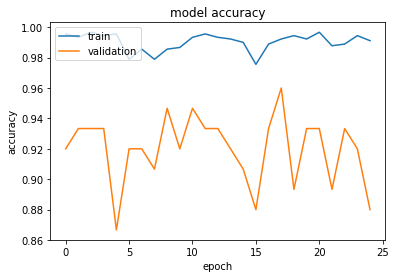

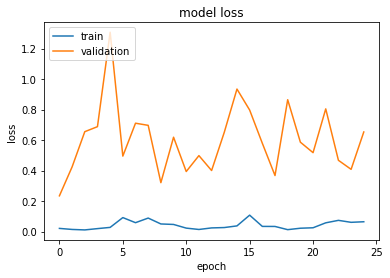

In [162]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [164]:
model = keras.models.load_model('mlt_dense_model_pcg.hdf5')

# Evaluate model

In [165]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True), steps=len(val_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

900/900 [==============================] - 43s 48ms/step


In [166]:
predictions.shape

(900, 6)

In [167]:
lc_predictions = predictions
#lc_predictions = np.asarray(predictions[0])
#canopy_pred = np.asarray(predictions[1])

In [168]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(val_px)*1*1)
pred_index = np.argmax(lc_predictions, axis=-1).reshape(len(val_px)*1*1)

Accuracy is 0.9211111111111111


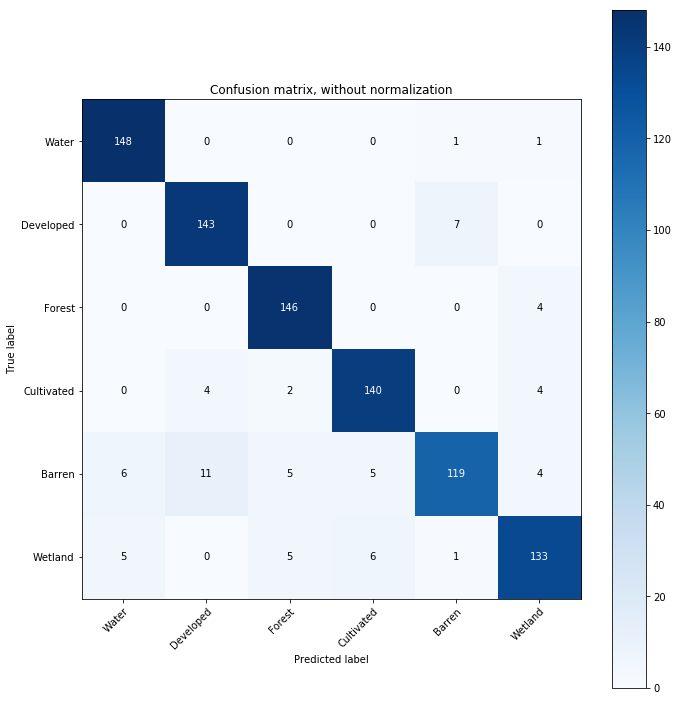

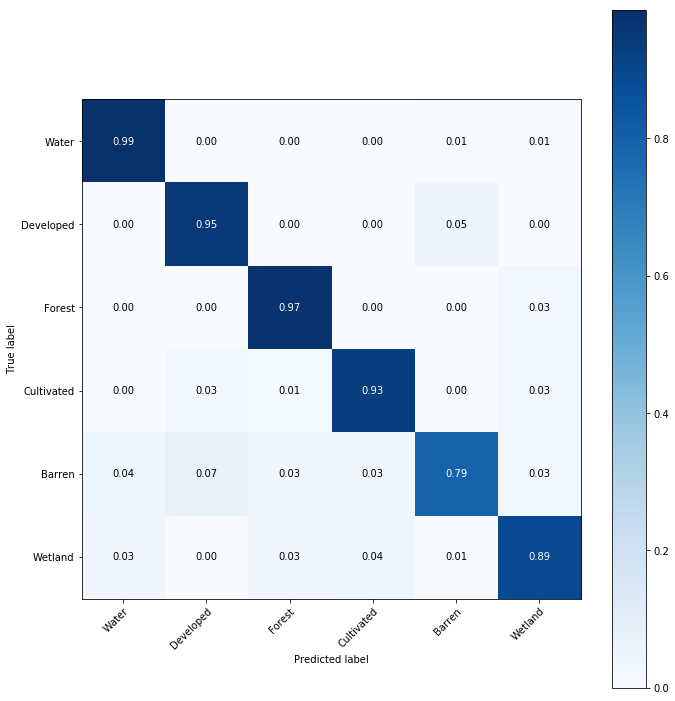

In [169]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
#experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
#experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1

val_accuracy=count/len(label_index)
print("Accuracy is",val_accuracy)

In [81]:
import pandas as pd
import seaborn as sns
pred_df = pd.DataFrame({'lc_pred': pred_index,
                        'lc_true': label_index})

In [83]:
params = {
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "clean_pixels_counts":clean_pixels_count,
    "max_count_per_class": max_count_per_class,
    "class_count_dict":['{} : {}'.format(k,v) for k,v in class_count_dict.items()],
    "steps_division_factor":steps_division_factor,
    "canopy_validation_r2":validation_r2,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [92]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/clifgray/chronos/a5ab88a2b72e437995d5b75c914c3e01
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [60]                      : (0.49066666579908796, 0.9865555513236258)
COMET INFO:     batch_acc [2160]              : (0.0, 1.0)
COMET INFO:     batch_loss [2160]             : (1.1920930376163597e-07, 16.11809539794922)
COMET INFO:     epoch_duration [60]           : (43.17310497400467, 52.04974722999032)
COMET INFO:     loss [60]                     : (0.04763108708932664, 7.529508348156296)
COMET INFO:     step                          : 23760
COMET INFO:     sys.gpu.0.free_memory [56]    : (444071936.0, 444071936.0)
COMET INFO:     sys.gpu.0.gpu_utilization [56]: (0.0, 66.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [56]    : (11552882688.0, 11552882688.0)


### Inspect Training Data

In [40]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True), steps=len(train_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)

7200/7200 [==============================] - 238s 33ms/step


In [41]:
lc_predictions_train = np.asarray(predictions[0])
canopy_pred_train = np.asarray(predictions[1])
lc_predictions_train = np.argmax(lc_predictions_train,axis=-1)

In [42]:
lc_lab_train = np.empty(lc_predictions_train.shape)
canopy_true_train = np.empty(canopy_pred_train.shape)
count = 0
while count < len(lc_predictions_train):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true_train[count] = label_b['canopy']
        lc_lab_train[count] = label_lc
        count += 1
label_index = lc_lab_train.reshape(len(train_px))
pred_index = lc_predictions_train.reshape(len(train_px))

((array([5540.,  104.,  111.,   79.,   46.,   56.,   63.,   97.,  248.,
          856.]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  <a list of 10 Patch objects>),
 (array([1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.10e+01, 5.76e+03,
         1.14e+02, 6.90e+01, 1.21e+02, 1.12e+03]),
  array([-1.21, -0.99, -0.76, -0.54, -0.31, -0.09,  0.14,  0.36,  0.59,
          0.81,  1.04], dtype=float32),
  <a list of 10 Patch objects>))

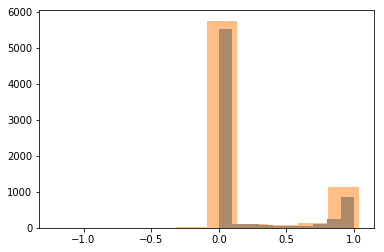

In [43]:
plt.hist(canopy_true_train, alpha=0.75), plt.hist(canopy_pred_train, alpha=0.5)

In [44]:
from sklearn.metrics import r2_score
r2_score(canopy_true_train, canopy_pred_train)

0.9298788612419028

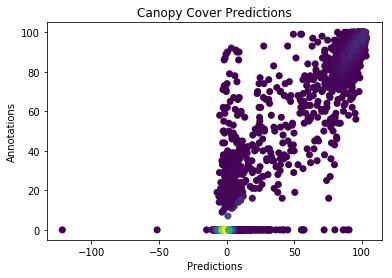

In [45]:
from scipy.stats import gaussian_kde

x = (canopy_pred_train * 100).flatten()
y = (canopy_true_train * 100).flatten()

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()

fig,ax = plt.subplots()
ax.scatter(x,y,c=z,s=50,edgecolor='')
ax.set_xlabel("Predictions")
ax.set_ylabel("Annotations")
ax.set_title("Canopy Cover Predictions")
plt.show()